In [243]:
POPU_STATE_PATH = '../data/processed/2020-2021-popu-estimate-by-state.csv'
PIT_BY_COC_PATH = '../data/processed/2015-2020-pit-demographic-by-coc.csv'
PIT_BY_STATE_PATH = '../data/processed/2007-2020-pit-estimates-by-state.csv'
STATE_CODE_PATH = '../data/raw/state_vs_code.csv'
MAP_PATH = '../data/maps/cb_2018_us_state_20m/cb_2018_us_state_20m.shp'

In [252]:
import pandas as pd
import geopandas as gpd
popu_df = pd.read_csv(POPU_STATE_PATH)
coc_df = pd.read_csv(PIT_BY_COC_PATH)
state_df = pd.read_csv(PIT_BY_STATE_PATH)
state_codes = pd.read_csv(STATE_CODE_PATH).rename(columns={'State': 'geographic_area', 'Code': 'State'})
state_codes.head()

,geographic_area,Abbrev,State
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [253]:
selected_cols = set(coc_df.columns)
selected_cols = selected_cols.intersection(set(state_df.columns))
selected_cols.add('State')


In [254]:
state_df = state_df[selected_cols]

In [255]:
#Select only records for 2020
popu_cols = ["popu_estimate_2020",	"popu_estimate_2021","State", "geographic_area"]
popu_df = popu_df.merge(state_codes[['geographic_area', 'State']], on='geographic_area')[popu_cols]
popu_df.head()
# state_codes

,popu_estimate_2020,popu_estimate_2021,State,geographic_area
0,5024803,5039877.0,AL,Alabama
1,732441,732673.0,AK,Alaska
2,7177986,7276316.0,AZ,Arizona
3,3012232,3025891.0,AR,Arkansas
4,39499738,39237836.0,CA,California


In [256]:
state_df_2020 = state_df[state_df['Year'] == 2020]
state_df_2020.head()

,Sheltered Total Homeless Individuals,Unsheltered Homeless - Gender Non-Conforming,Unsheltered Homeless Individuals,Sheltered Total Homeless - Asian,Sheltered Total Homeless - Over 24,Unsheltered Homeless Individuals - American Indian or Alaska Native,Overall Homeless Individuals - Female,Unsheltered Homeless - Asian,Unsheltered Homeless Individuals - Black or African American,Sheltered Total Homeless Individuals - Gender Non-Conforming,...,Unsheltered Homeless Individuals - Under 18,Overall Homeless Veterans,Sheltered Total Homeless - White,Unsheltered Homeless Individuals - Multiple Races,Overall Homeless Individuals - Black or African American,Sheltered Total Homeless - Age 18 to 24,Sheltered Total Homeless Individuals - Male,Unsheltered Homeless - Under 18,Overall Homeless,Sheltered Total Homeless Individuals - Asian
0,1224,0,221,22,1209,111,528,0,4,4,...,0,94,538,12,90,191,747,1,1949,15
1,1293,4,1204,2,1450,22,780,0,572,0,...,4,329,850,26,1258,124,837,50,3351,1
2,870,1,1203,2,859,19,616,2,431,1,...,2,188,599,23,778,81,575,42,2366,2
3,,,,,,,,,,,...,,,,,,,,,,
4,3002,12,5278,46,3516,568,2611,31,694,2,...,5,921,3016,214,1333,352,2045,132,10979,26


In [257]:
usa = gpd.read_file(MAP_PATH).rename(columns={'STUSPS': 'State'})[['State', 'geometry']]
usa.head()

,State,geometry
0,MD,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,IA,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,DE,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,OH,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,PA,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [258]:
popu_df = popu_df.merge(usa, on='State')
popu_df.head()

,popu_estimate_2020,popu_estimate_2021,State,geographic_area,geometry
0,5024803,5039877.0,AL,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
1,732441,732673.0,AK,Alaska,"MULTIPOLYGON (((179.48132 51.97530, 179.58286 ..."
2,7177986,7276316.0,AZ,Arizona,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
3,3012232,3025891.0,AR,Arkansas,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
4,39499738,39237836.0,CA,California,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."


In [259]:
import folium
import branca.colormap as cm


In [260]:
popu_df = gpd.GeoDataFrame(popu_df, geometry="geometry")
popu_df.crs = usa.crs
popu_df = popu_df.to_crs('EPSG:4326')


In [261]:
popu_geo = gpd.GeoSeries(popu_df.set_index('State')['geometry']).to_json()


In [262]:
def create_map(df, viz_col, index_col):
    mymap = folium.Map(location=[39.60688671643651, -93.46949406298138], zoom_start=3,tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
    geo = gpd.GeoSeries(df.set_index(index_col)['geometry']).to_json()
    # myscale = (popu_df['popu_estimate_2020'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
    folium.Choropleth(
    titles='My title',
    geo_data=geo,
    name='Choropleth',
    data=df,
    columns=[index_col, viz_col],
    key_on="feature.id",
    fill_color='YlGnBu',
    fill_opacity=0.6,
    line_opacity=1,
    legend_name='Population %',
    smooth_factor=0
    ).add_to(mymap)
    return mymap
        
    

### Population by State

In [263]:
create_map(popu_df, 'popu_estimate_2020', 'State')


In [264]:
viz_cols = ['Overall Homeless', 'Sheltered Total Homeless', 'Unsheltered Homeless']
state_norm = state_df_2020[['State'] + viz_cols + ['Year']].merge(popu_df, on='State')

for col in viz_cols:
    state_norm = state_norm.astype({col:'int32'})
    state_norm[col + ' Norm'] = state_norm[col]/state_norm['popu_estimate_2021']
    

In [265]:
state_norm.head()

,State,Overall Homeless,Sheltered Total Homeless,Unsheltered Homeless,Year,popu_estimate_2020,popu_estimate_2021,geographic_area,geometry,Overall Homeless Norm,Sheltered Total Homeless Norm,Unsheltered Homeless Norm
0,AK,1949,1725,224,2020,732441,732673.0,Alaska,"MULTIPOLYGON (((179.48132 51.97531, 179.58286 ...",0.002660,0.002354,0.000306
1,AL,3351,2052,1299,2020,5024803,5039877.0,Alabama,"POLYGON ((-88.46866 31.89385, -88.46866 31.933...",0.000665,0.000407,0.000258
2,AR,2366,1093,1273,2020,3012232,3025891.0,Arkansas,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",0.000782,0.000361,0.000421
3,AZ,10979,5458,5521,2020,7177986,7276316.0,Arizona,"POLYGON ((-114.79968 32.59362, -114.80939 32.6...",0.001509,0.000750,0.000759
4,CA,161548,47888,113660,2020,39499738,39237836.0,California,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847...",0.004117,0.001220,0.002897


### Overall Homeless  Normalized by Population

In [266]:
create_map(state_norm, 'Overall Homeless Norm', 'State')

### Sheltered Total Homeless Normalized by Population

In [267]:
create_map(state_norm, 'Sheltered Total Homeless Norm', 'State')

### Unsheltered Homeless Normalized by Population

In [268]:
create_map(state_norm, 'Unsheltered Homeless Norm', 'State')

### **Top 10 states with highest/lowest homelessness count**

#### Top 10 states with highest homelessness count

In [273]:
state_norm.sort_values(by='Overall Homeless Norm', ascending=False)[['geographic_area', 'Overall Homeless Norm', 'Overall Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Overall Homeless Norm,Overall Homeless,popu_estimate_2020
0,District of Columbia,0.009522,6380,690093
1,New York,0.004601,91271,20154933
2,Hawaii,0.004480,6458,1451911
3,California,0.004117,161548,39499738
4,Oregon,0.003451,14655,4241544
5,Washington,0.002962,22923,7718785
6,Alaska,0.002660,1949,732441
7,Massachusetts,0.002573,17975,7022220
8,Nevada,0.002195,6900,3114071
9,Vermont,0.001719,1110,642495


In [278]:
state_norm.sort_values(by='Sheltered Total Homeless Norm', ascending=False)[['geographic_area', 'Sheltered Total Homeless Norm', 'Sheltered Total Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Sheltered Total Homeless Norm,Sheltered Total Homeless,popu_estimate_2020
0,District of Columbia,0.008547,5727,690093
1,New York,0.004372,86714,20154933
2,Massachusetts,0.002388,16681,7022220
3,Alaska,0.002354,1725,732441
4,Hawaii,0.001948,2808,1451911
5,Washington,0.001565,12109,7718785
6,Vermont,0.001543,996,642495
7,Maine,0.001425,1956,1362280
8,Oregon,0.001361,5778,4241544
9,California,0.001220,47888,39499738


In [283]:
state_norm.sort_values(by='Unsheltered Homeless Norm', ascending=False)[['geographic_area', 'Unsheltered Homeless Norm', 'Unsheltered Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Unsheltered Homeless Norm,Unsheltered Homeless,popu_estimate_2020
0,California,0.002897,113660,39499738
1,Hawaii,0.002532,3650,1451911
2,Oregon,0.002091,8877,4241544
3,Washington,0.001397,10814,7718785
4,Nevada,0.001339,4209,3114071
5,District of Columbia,0.000975,653,690093
6,Arizona,0.000759,5521,7177986
7,New Mexico,0.000595,1259,2117566
8,Florida,0.000582,12672,21569932
9,Idaho,0.000549,1043,1847772


#### Top 10 states with lowest homelessness count

In [276]:
state_norm.sort_values(by='Overall Homeless Norm', ascending=True)[['geographic_area', 'Overall Homeless Norm', 'Overall Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Overall Homeless Norm,Overall Homeless,popu_estimate_2020
0,Mississippi,0.000375,1107,2956870
1,Alabama,0.000665,3351,5024803
2,Louisiana,0.000686,3173,4651203
3,Virginia,0.000689,5957,8632044
4,North Dakota,0.000698,541,778962
5,West Virginia,0.000752,1341,1789798
6,Wisconsin,0.000766,4515,5892323
7,Arkansas,0.000782,2366,3012232
8,Connecticut,0.000806,2905,3600260
9,Illinois,0.000823,10431,12785245


In [282]:
state_norm.sort_values(by='Sheltered Total Homeless Norm', ascending=True)[['geographic_area', 'Sheltered Total Homeless Norm', 'Sheltered Total Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Sheltered Total Homeless Norm,Sheltered Total Homeless,popu_estimate_2020
0,Mississippi,0.000197,581,2956870
1,Arkansas,0.000361,1093,3012232
2,Alabama,0.000407,2052,5024803
3,Louisiana,0.000437,2020,4651203
4,Texas,0.000475,14017,29217653
5,South Carolina,0.000498,2583,5130729
6,Georgia,0.000563,6078,10725800
7,Virginia,0.000577,4989,8632044
8,West Virginia,0.000597,1064,1789798
9,North Carolina,0.000637,6722,10457177


In [284]:
state_norm.sort_values(by='Unsheltered Homeless Norm', ascending=True)[['geographic_area', 'Unsheltered Homeless Norm', 'Unsheltered Homeless', 'popu_estimate_2020']].reset_index(drop=True).head(10)

,geographic_area,Unsheltered Homeless Norm,Unsheltered Homeless,popu_estimate_2020
0,North Dakota,0.000044,34,778962
1,Wisconsin,0.000055,324,5892323
2,Nebraska,0.000073,143,1961455
3,Connecticut,0.000090,325,3600260
4,Rhode Island,0.000099,108,1096229
5,Maine,0.000103,141,1362280
6,Michigan,0.000103,1039,10067664
7,Iowa,0.000104,333,3188669
8,Virginia,0.000112,968,8632044
9,Indiana,0.000142,966,6785644


In [300]:
state_norm.loc[state_norm.sort_values(by='Unsheltered Homeless Norm', ascending=False).index, 'Unsheltered Homeless Rank'] = list(range(1, len(state_norm) + 1))
state_norm.loc[state_norm.sort_values(by='Sheltered Total Homeless Norm', ascending=False).index, 'Sheltered Total Homeless Rank'] = list(range(1, len(state_norm) + 1))
state_norm.loc[state_norm.sort_values(by='Overall Homeless Norm', ascending=False).index, 'Overall Homeless Rank'] = list(range(1, len(state_norm) + 1))

In [304]:
state_norm[['geographic_area', "Overall Homeless Rank", "Unsheltered Homeless Rank",	"Sheltered Total Homeless Rank"]]

,geographic_area,Overall Homeless Rank,Unsheltered Homeless Rank,Sheltered Total Homeless Rank
0,Alaska,7,20,4
1,Alabama,50,23,49
2,Arkansas,44,13,50
3,Arizona,14,7,27
4,California,4,1,10
5,Colorado,11,11,11
6,Connecticut,43,48,31
7,District of Columbia,1,6,1
8,Delaware,22,40,14
9,Florida,17,9,35


## Scatterplot Overall Homeless Rank vs Unsheltered Homeless Rank vs Sheltered Homeless


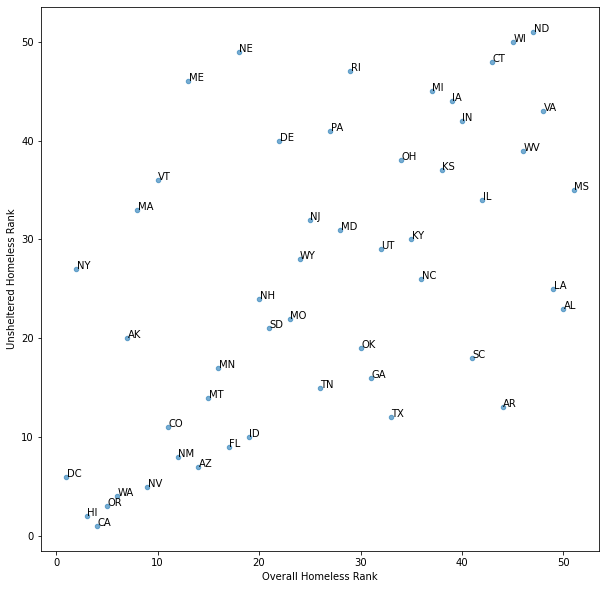

In [324]:
from matplotlib import pyplot as plt
ax = state_norm.plot.scatter(x='Overall Homeless Rank', y='Unsheltered Homeless Rank', figsize=(10, 10), s=20, alpha=0.6)
for i, txt in enumerate(state_norm.State):
   ax.annotate(txt, (state_norm['Overall Homeless Rank'].iat[i]+0.05, state_norm['Unsheltered Homeless Rank'].iat[i]), )
plt.show()

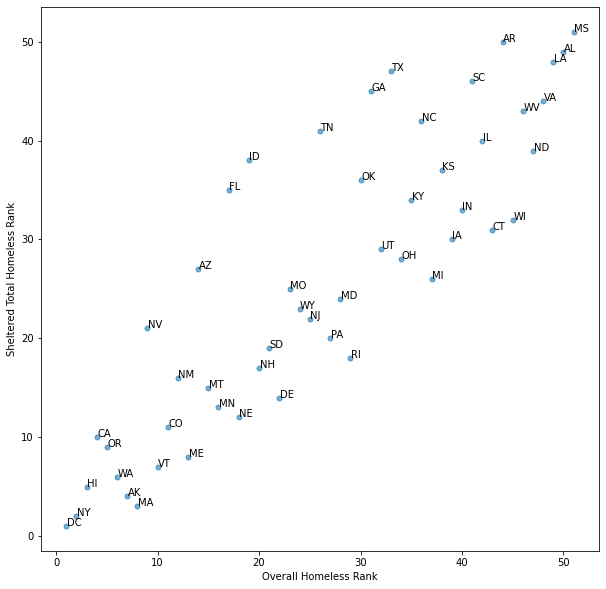

In [320]:
from matplotlib import pyplot as plt
ax = state_norm.plot.scatter(x='Overall Homeless Rank', y='Sheltered Total Homeless Rank', figsize=(10, 10), alpha=0.6, s=25)
for i, txt in enumerate(state_norm.State):
   ax.annotate(txt, (state_norm['Overall Homeless Rank'].iat[i]+0.05, state_norm['Sheltered Total Homeless Rank'].iat[i]))
plt.show()

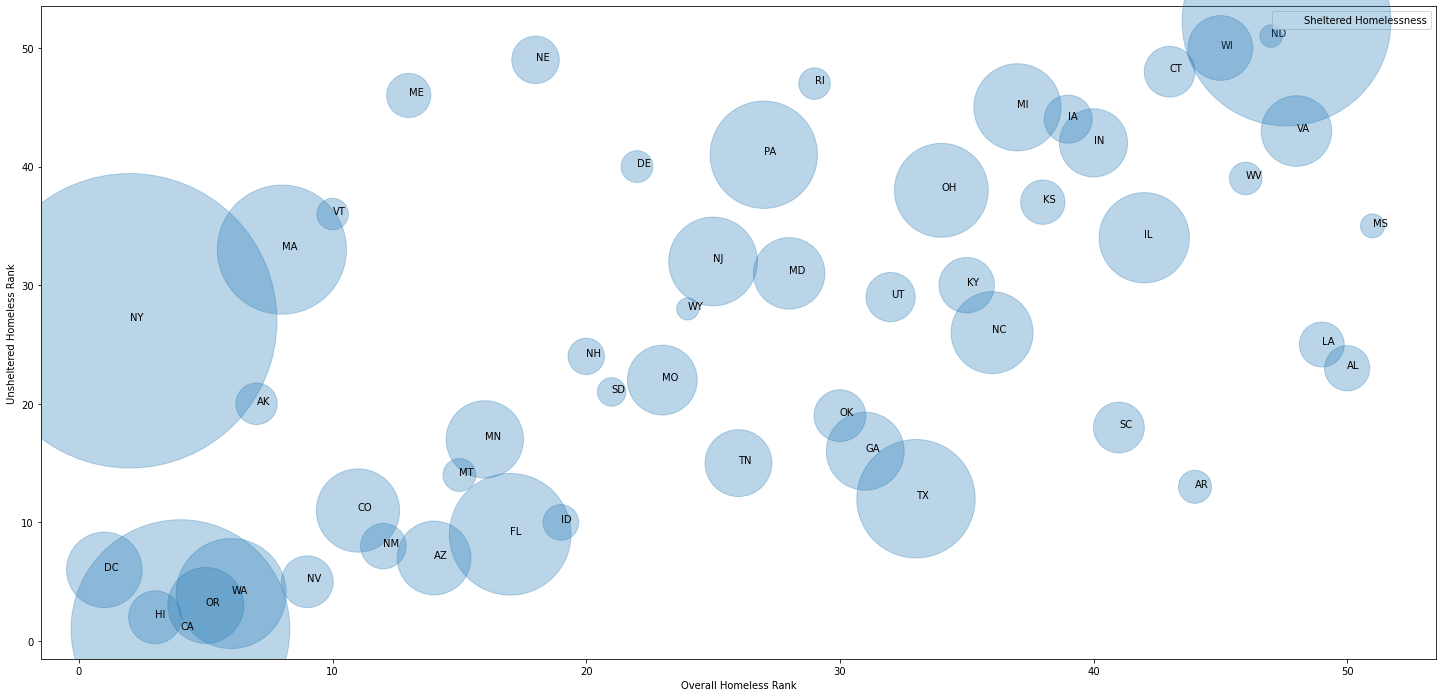

In [334]:
from matplotlib import pyplot as plt
ax = state_norm.plot.scatter(x='Overall Homeless Rank', y='Unsheltered Homeless Rank', figsize=(25, 12), s='Sheltered Total Homeless', alpha=0.3, label="Sheltered Homelessness")
for i, txt in enumerate(state_norm.State):
   ax.annotate(txt, (state_norm['Overall Homeless Rank'].iat[i], state_norm['Unsheltered Homeless Rank'].iat[i]), )
plt.show()